In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import image

from os import listdir
from os.path import isfile, join

import tensorflow as tf

from tensorflow.keras import callbacks, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D
from keras.applications import MobileNet, EfficientNetB3
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import average_precision_score

2025-10-24 11:04:35.169316: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 11:04:35.180532: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761296675.194622  496366 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761296675.199445  496366 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-24 11:04:35.212734: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Note: Use conda tf-gpu environment. Copy of exp3 with more data

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
spec_dir = '../data/image_data/'
sample_dir = '../data/image_data/Polistes_dominula/'

paths_sample_plot = [join(sample_dir, f) for f in listdir(sample_dir) if isfile(join(sample_dir, f))]

- (b) View Batch

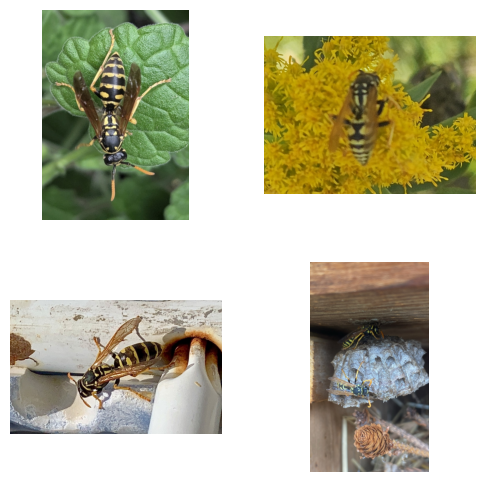

In [4]:
plt.figure(figsize=(6,6))

plt.subplot(221)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(222)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(223)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]))

plt.subplot(224)
plt.axis('off')
plt.imshow(image.imread(paths_sample_plot[np.random.randint(len(paths_sample_plot))]));

Define Batch size

In [5]:
batch_size = 32

## B - <a name="generateurs"></a> Data Generators



In [6]:
train_data_generator = ImageDataGenerator(rescale = 1./255,
                                    validation_split = 0.2,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    brightness_range=(0.8, 1.2),
                                    fill_mode='nearest'
                                   )

val_data_generator = ImageDataGenerator(rescale = 1./255,
                                   validation_split = 0.2,
                                   )

test_data_generator  = ImageDataGenerator(rescale = 1./255)
data_generator  = ImageDataGenerator(rescale = 1./255)

- (d) Implement ```training_data```, ```valid_data``` splits


In [7]:
training_data  = train_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "training", 
                                                   batch_size = batch_size)

validation_data  = val_data_generator.flow_from_directory(directory = spec_dir,
                                                   target_size = (224, 224),
                                                   class_mode = 'binary',
                                                   subset = "validation", 
                                                   batch_size = batch_size)

#test_data  = test_data_generator.flow_from_directory(directory = spec_dir,
#                                                   target_size = (224, 224),
#                                                   class_mode = 'binary',
#                                                   batch_size = batch_size)


Found 26030 images belonging to 127 classes.
Found 6477 images belonging to 127 classes.


# II - <a name="classif"></a> Classification



In [8]:
# Model MobileNet
base_model = MobileNet(weights='imagenet', include_top=False)

# Freezer les couches
#for layer in base_model.layers:
#    layer.trainable = False


"""
# Unfreeze the last N trainable convolutional blocks
trainable = False
for layer in reversed(base_model.layers):
    if 'conv' in layer.name:
        if N == 0:
            break
        N -= 1
        trainable = True
    layer.trainable = trainable
"""

model = Sequential()
model.add(base_model) # Ajout du modèl
model.add(GlobalAveragePooling2D())
model.add(Dropout(rate=0.3))
model.add(Dense(units=1024, activation='relu'))
model.add(Dense(127, activation='softmax'))

/tmp/ipykernel_496366/3838958738.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNet(weights='imagenet', include_top=False)
I0000 00:00:1761296680.822697  496366 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47179 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5
I0000 00:00:1761296680.823954  496366 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46919 MB memory:  -> device: 1, name: Quadro RTX 8000, pci bus id: 0000:b6:00.0, compute capability: 7.5


In [9]:
early_stopping = callbacks.EarlyStopping(monitor = 'val_accuracy',
                                         patience = 10,
                                         mode = 'max',
                                         restore_best_weights = True)

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                        patience=4,
                                         factor=0.5,
                                         verbose=2,
                                         mode='max',
                                         min_lr = 1e-10)

In [10]:
optimizer = Adam(learning_rate=0.001) 

In [11]:
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

class AveragePrecisionCallback(tf.keras.callbacks.Callback):
    def __init__(self, val_generator, num_classes=127):
        super().__init__()
        self.val_generator = val_generator
        self.num_classes = num_classes

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for i in range(len(self.val_generator)):
            x_batch, y_batch = self.val_generator[i]  # y_batch: shape (batch_size,)
            preds = self.model.predict(x_batch, verbose=0)  # preds: shape (batch_size, num_classes)

            y_true.extend(y_batch)
            y_pred.extend(preds)

        y_true = np.array(y_true)
        y_pred = np.array(y_pred)

        # One-hot encode y_true to match y_pred's shape
        y_true_onehot = label_binarize(y_true, classes=range(self.num_classes))

        # Compute average precision per class
        aps = []
        for i in range(self.num_classes):
            ap = average_precision_score(y_true_onehot[:, i], y_pred[:, i])
            aps.append(ap)

        macro_ap = np.mean(aps)
        print(f"\nEpoch {epoch + 1}: val_average_precision = {macro_ap:.4f}")
        logs = logs or {}
        logs['val_average_precision'] = macro_ap


In [12]:
ap_callback = AveragePrecisionCallback(val_generator=validation_data)

In [13]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(training_data, validation_data=validation_data, epochs=30, 
                    callbacks=[ap_callback,lr_plateau, early_stopping])

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30


I0000 00:00:1761296692.632865  496620 service.cc:148] XLA service 0x7b4c40002020 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761296692.632913  496620 service.cc:156]   StreamExecutor device (0): Quadro RTX 8000, Compute Capability 7.5
I0000 00:00:1761296692.632920  496620 service.cc:156]   StreamExecutor device (1): Quadro RTX 8000, Compute Capability 7.5
2025-10-24 11:04:52.944629: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1761296693.916130  496620 cuda_dnn.cc:529] Loaded cuDNN version 91200
E0000 00:00:1761296695.696909  496620 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761296695.822064  496620 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. T

582/814 ━━━━━━━━━━━━━━━━━━━━ 1:27 379ms/step - accuracy: 0.1317 - loss: 3.8833

E0000 00:00:1761296931.639894  496618 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761296931.764694  496618 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761296934.331942  496618 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761296934.455572  496618 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761296936.135598  496618 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:0

814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.1560 - loss: 3.6862

E0000 00:00:1761297064.939164  496622 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761297065.064592  496622 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761297067.980561  496622 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761297068.104443  496622 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1761297068.228122  496622 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
/home/haka


Epoch 1: val_average_precision = 0.2237
814/814 ━━━━━━━━━━━━━━━━━━━━ 439s 509ms/step - accuracy: 0.2336 - loss: 3.0968 - val_accuracy: 0.1970 - val_loss: 3.7306 - val_average_precision: 0.2237 - learning_rate: 0.0010
Epoch 2/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - accuracy: 0.3790 - loss: 2.2821

/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(



Epoch 2: val_average_precision = 0.4222
814/814 ━━━━━━━━━━━━━━━━━━━━ 392s 481ms/step - accuracy: 0.3971 - loss: 2.2138 - val_accuracy: 0.4039 - val_loss: 2.1891 - val_average_precision: 0.4222 - learning_rate: 0.0010
Epoch 3/30
814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.4756 - loss: 1.8772
Epoch 3: val_average_precision = 0.4385
814/814 ━━━━━━━━━━━━━━━━━━━━ 372s 457ms/step - accuracy: 0.4799 - loss: 1.8695 - val_accuracy: 0.4144 - val_loss: 2.2227 - val_average_precision: 0.4385 - learning_rate: 0.0010
Epoch 4/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5199 - loss: 1.6844
Epoch 4: val_average_precision = 0.4414
814/814 ━━━━━━━━━━━━━━━━━━━━ 377s 463ms/step - accuracy: 0.5285 - loss: 1.6647 - val_accuracy: 0.4087 - val_loss: 2.3032 - val_average_precision: 0.4414 - learning_rate: 0.0010
Epoch 5/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.5690 - loss: 1.4993
Epoch 5: val_average_precision = 0.5101
814/814 ━━━━━━━━━━━━━━━━━━━━ 372s 457ms/step - accuracy: 0.5659 - loss: 1.5040 - val_accuracy: 0.4965 - val_loss: 1.8869 - val_average_precision: 0.5101 - learning_rate: 0.0010
Epoch 6/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.5986 - loss: 1.3859
Epoch 6: val_average_precision = 0.5083
814/814 ━━━━━━━━━━━━━━━━━━━━ 373s 459ms/step - accuracy: 0.5947 - loss: 1.3979 - val_accuracy: 0.4816 - val_loss: 1.9430 - val_average_precision: 0.5083 - learning_rate: 0.0010
Epoch 7/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6229 - loss: 1.2795
Epoch 7: val_average_precision = 0.5580
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 453ms/step - accuracy: 0.6217 - loss: 1.2875 - val_accuracy: 0.5330 - val_loss: 1.7779 - val_average_precision: 0.5580 - learning_rate: 0.0010
Epoch 8/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.6561 - loss: 1.1677
Epoch 8: val_average_precision = 0.5406
814/814 ━━━━━━━━━━━━━━━━━━━━ 370s 454ms/step - accuracy: 0.6467 - loss: 1.1985 - val_accuracy: 0.5039 - val_loss: 1.8755 - val_average_precision: 0.5406 - learning_rate: 0.0010
Epoch 9/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.6625 - loss: 1.1197
Epoch 9: val_average_precision = 0.5957
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 453ms/step - accuracy: 0.6629 - loss: 1.1256 - val_accuracy: 0.5799 - val_loss: 1.5409 - val_average_precision: 0.5957 - learning_rate: 0.0010
Epoch 10/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.6859 - loss: 1.0488
Epoch 10: val_average_precision = 0.6005
814/814 ━━━━━━━━━━━━━━━━━━━━ 371s 456ms/step - accuracy: 0.6813 - loss: 1.0605 - val_accuracy: 0.5827 - val_loss: 1.5666 - val_average_precision: 0.6005 - learning_rate: 0.0010
Epoch 11/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.7011 - loss: 0.9865
Epoch 11: val_average_precision = 0.6016
814/814 ━━━━━━━━━━━━━━━━━━━━ 371s 455ms/step - accuracy: 0.6977 - loss: 1.0089 - val_accuracy: 0.5725 - val_loss: 1.6724 - val_average_precision: 0.6016 - learning_rate: 0.0010
Epoch 12/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.7128 - loss: 0.9290
Epoch 12: val_average_precision = 0.6085
814/814 ━━━━━━━━━━━━━━━━━━━━ 363s 446ms/step - accuracy: 0.7093 - loss: 0.9582 - val_accuracy: 0.5926 - val_loss: 1.5738 - val_average_precision: 0.6085 - learning_rate: 0.0010
Epoch 13/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7341 - loss: 0.8704
Epoch 13: val_average_precision = 0.6262
814/814 ━━━━━━━━━━━━━━━━━━━━ 368s 452ms/step - accuracy: 0.7268 - loss: 0.8965 - val_accuracy: 0.6041 - val_loss: 1.4847 - val_average_precision: 0.6262 - learning_rate: 0.0010
Epoch 14/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.7482 - loss: 0.8076
Epoch 14: val_average_precision = 0.6288
814/814 ━━━━━━━━━━━━━━━━━━━━ 375s 460ms/step - accuracy: 0.7358 - loss: 0.8530 - val_accuracy: 0.6086 - val_loss: 1.5038 - val_average_precision: 0.6288 - learning_rate: 0.0010
Epoch 15/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7583 - loss: 0.7738
Epoch 15: val_average_precision = 0.6179
814/814 ━━━━━━━━━━━━━━━━━━━━ 374s 460ms/step - accuracy: 0.7481 - loss: 0.8087 - val_accuracy: 0.5845 - val_loss: 1.6472 - val_average_precision: 0.6179 - learning_rate: 0.0010
Epoch 16/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7704 - loss: 0.7363
Epoch 16: val_average_precision = 0.6353
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 453ms/step - accuracy: 0.7589 - loss: 0.7749 - val_accuracy: 0.6146 - val_loss: 1.5164 - val_average_precision: 0.6353 - learning_rate: 0.0010
Epoch 17/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.7808 - loss: 0.6823
Epoch 17: val_average_precision = 0.6106
814/814 ━━━━━━━━━━━━━━━━━━━━ 367s 450ms/step - accuracy: 0.7729 - loss: 0.7189 - val_accuracy: 0.5963 - val_loss: 1.5633 - val_average_precision: 0.6106 - learning_rate: 0.0010
Epoch 18/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.7883 - loss: 0.6658
Epoch 18: val_average_precision = 0.6495
814/814 ━━━━━━━━━━━━━━━━━━━━ 368s 452ms/step - accuracy: 0.7783 - loss: 0.6995 - val_accuracy: 0.6310 - val_loss: 1.4699 - val_average_precision: 0.6495 - learning_rate: 0.0010
Epoch 19/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.7994 - loss: 0.6350
Epoch 19: val_average_precision = 0.6442
814/814 ━━━━━━━━━━━━━━━━━━━━ 371s 456ms/step - accuracy: 0.7898 - loss: 0.6652 - val_accuracy: 0.6324 - val_loss: 1.4559 - val_average_precision: 0.6442 - learning_rate: 0.0010
Epoch 20/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8064 - loss: 0.6094
Epoch 20: val_average_precision = 0.6467
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 454ms/step - accuracy: 0.7950 - loss: 0.6486 - val_accuracy: 0.6395 - val_loss: 1.4571 - val_average_precision: 0.6467 - learning_rate: 0.0010
Epoch 21/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8171 - loss: 0.5809
Epoch 21: val_average_precision = 0.6399
814/814 ━━━━━━━━━━━━━━━━━━━━ 367s 451ms/step - accuracy: 0.8059 - loss: 0.6033 - val_accuracy: 0.6208 - val_loss: 1.6145 - val_average_precision: 0.6399 - learning_rate: 0.0010
Epoch 22/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8249 - loss: 0.5551
Epoch 22: val_average_precision = 0.6699
814/814 ━━━━━━━━━━━━━━━━━━━━ 367s 450ms/step - accuracy: 0.8189 - loss: 0.5700 - val_accuracy: 0.6494 - val_loss: 1.3926 - val_average_precision: 0.6699 - learning_rate: 0.0010
Epoch 23/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.8272 - loss: 0.5318
Epoch 23: val_average_precision = 0.6386
814/814 ━━━━━━━━━━━━━━━━━━━━ 374s 459ms/step - accuracy: 0.8224 - loss: 0.5544 - val_accuracy: 0.6418 - val_loss: 1.5127 - val_average_precision: 0.6386 - learning_rate: 0.0010
Epoch 24/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step - accuracy: 0.8370 - loss: 0.5038
Epoch 24: val_average_precision = 0.6218
814/814 ━━━━━━━━━━━━━━━━━━━━ 371s 455ms/step - accuracy: 0.8330 - loss: 0.5210 - val_accuracy: 0.6102 - val_loss: 1.6713 - val_average_precision: 0.6218 - learning_rate: 0.0010
Epoch 25/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8382 - loss: 0.4927
Epoch 25: val_average_precision = 0.6694
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 453ms/step - accuracy: 0.8340 - loss: 0.5133 - val_accuracy: 0.6602 - val_loss: 1.3936 - val_average_precision: 0.6694 - learning_rate: 0.0010
Epoch 26/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8472 - loss: 0.4640
Epoch 26: val_average_precision = 0.6545
814/814 ━━━━━━━━━━━━━━━━━━━━ 370s 454ms/step - accuracy: 0.8409 - loss: 0.4889 - val_accuracy: 0.6421 - val_loss: 1.4983 - val_average_precision: 0.6545 - learning_rate: 0.0010
Epoch 27/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.8527 - loss: 0.4435
Epoch 27: val_average_precision = 0.6527
814/814 ━━━━━━━━━━━━━━━━━━━━ 369s 453ms/step - accuracy: 0.8475 - loss: 0.4699 - val_accuracy: 0.6335 - val_loss: 1.5277 - val_average_precision: 0.6527 - learning_rate: 0.0010
Epoch 28/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.8585 - loss: 0.4319
Epoch 28: val_average_precision = 0.6422
814/814 ━━━━━━━━━━━━━━━━━━━━ 368s 452ms/step - accuracy: 0.8518 - loss: 0.4553 - val_accuracy: 0.6346 - val_loss: 1.5715 - val_average_precision: 0.6422 - learning_rate: 0.0010
Epoch 29/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.8650 - loss: 0.4049
Epoch 29: val_average_precision = 0.6590

Epoch 29: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
814/814 ━━━━━━━━━━━━━━━━━━━━ 372s 457ms/step - accuracy: 0.8595 - loss: 0.4306 - val_accuracy: 0.6443 - val_loss: 1.5352 - val_average_precision: 0.6590 - learning_rate: 0.0010
Epoch 30/30


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


814/814 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8967 - loss: 0.3005
Epoch 30: val_average_precision = 0.6973
814/814 ━━━━━━━━━━━━━━━━━━━━ 371s 456ms/step - accuracy: 0.9051 - loss: 0.2812 - val_accuracy: 0.6855 - val_loss: 1.5232 - val_average_precision: 0.6973 - learning_rate: 5.0000e-04


/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/home/hakandogan/.conda/envs/tf-gpu/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:1046: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


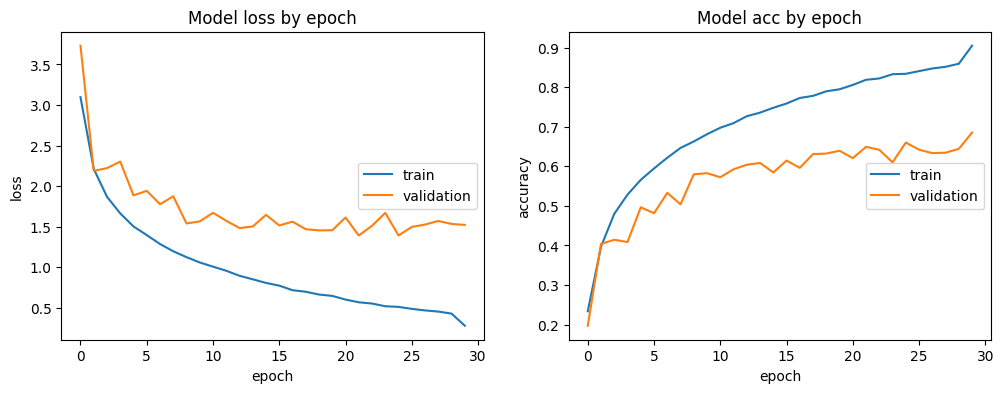

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')

plt.subplot(122)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model acc by epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='right')
plt.show()

In [16]:
model.save('../models/model_127_species_exp7.h5')